In [41]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### CLEANING UP THE IMAGES

In [5]:
!pip3 install opencv-python

In [6]:
import cv2
import imghdr

In [7]:
data_dir = 'data'

In [8]:
img_exts = ['jpeg','jpg','bmp','png']

In [9]:
for image_class in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_dir):  # Check if it's a directory before proceeding
        continue
    for image in os.listdir(class_dir):
        img_path = os.path.join(class_dir, image)
        try:
            img = cv2.imread(img_path)
            tip = imghdr.what(img_path)
            if tip not in img_exts:
                print("Invalid image extension: {}".format(img_path))
                os.remove(img_path)
        except Exception as e:
            print("Issue with image: {}".format(img_path))
            os.remove(img_path)

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 148 files belonging to 2 classes.


2023-08-08 09:56:23.688850: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-08-08 09:56:23.688877: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-08-08 09:56:23.688881: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-08-08 09:56:23.689681: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-08 09:56:23.690069: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
data_iterator = data.as_numpy_iterator()

In [17]:
batch = data_iterator.next()

In [18]:
len(batch)

2

In [19]:
batch[0].shape

(32, 256, 256, 3)

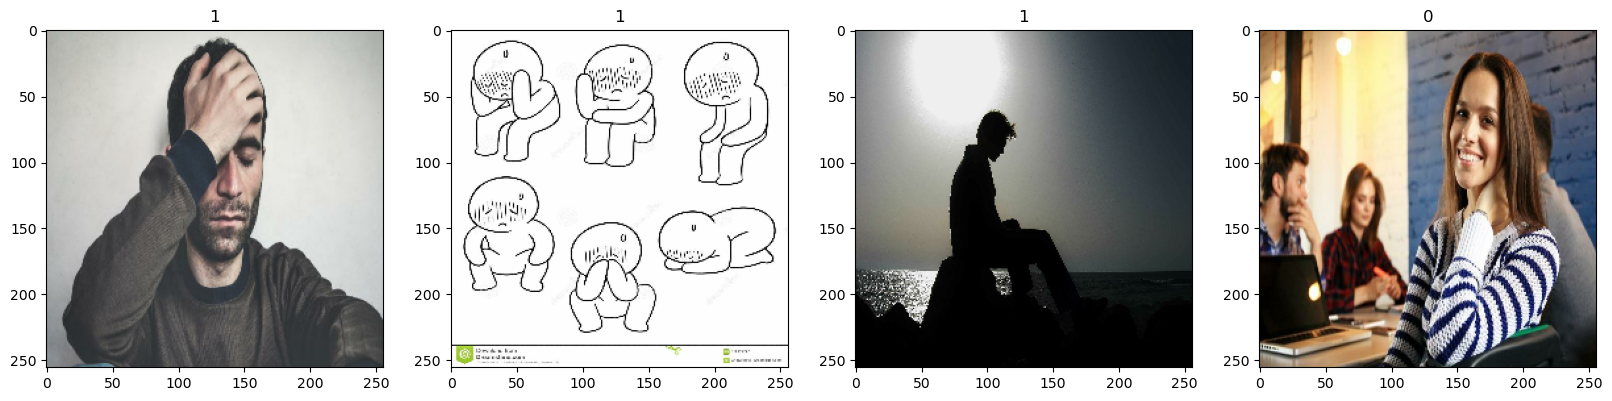

In [20]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [21]:
# HAPPY - 0
# SAD - 1

### PREPROCESS DATA

In [22]:
data = data.map(lambda x, y : (x/255, y))

In [23]:
scaled = data.as_numpy_iterator().next()

In [24]:
scaled[0].min()

0.0

In [25]:
scaled[0].max()

1.0

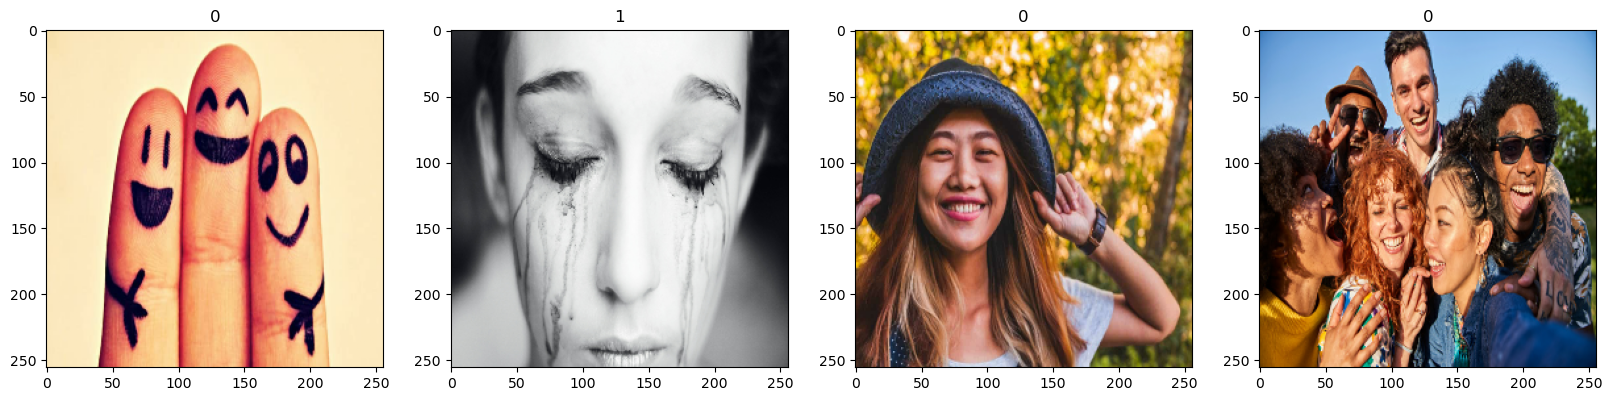

In [26]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(scaled[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(scaled[1][idx])

In [27]:
len(data)

5

In [28]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [29]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### FUN PART

#### DEEP LEARING MODEL

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [44]:
model = Sequential()

In [45]:
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [46]:
optimizer = tf.keras.optimizers.legacy.Adam()

In [47]:
model.compile(optimizer = optimizer,loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

### TRAINING

In [49]:
logdir = 'logs'

In [50]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [51]:
history = model.fit(train, epochs = 100, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/100


2023-08-08 10:01:02.539812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 2.1057 - accuracy: 0.5521

2023-08-08 10:01:03.730085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 523ms/step - loss: 2.1057 - accuracy: 0.5521 - val_loss: 0.8231 - val_accuracy: 0.5625
Epoch 2/100
3/3 [==============================] - 2s 476ms/step - loss: 0.8486 - accuracy: 0.4792 - val_loss: 0.8098 - val_accuracy: 0.4688
Epoch 3/100
3/3 [==============================] - 2s 479ms/step - loss: 0.7612 - accuracy: 0.4062 - val_loss: 0.7233 - val_accuracy: 0.4375
Epoch 4/100
3/3 [==============================] - 2s 477ms/step - loss: 0.6795 - accuracy: 0.5521 - val_loss: 0.6557 - val_accuracy: 0.5938
Epoch 5/100
3/3 [==============================] - 2s 474ms/step - loss: 0.6112 - accuracy: 0.6146 - val_loss: 0.5602 - val_accuracy: 0.8125
Epoch 6/100
3/3 [==============================] - 2s 471ms/step - loss: 0.5795 - accuracy: 0.7396 - val_loss: 0.6052 - val_accuracy: 0.6250
Epoch 7/100
3/3 [==============================] - 2s 471ms/step - loss: 0.6321 - accuracy: 0.6042 - val_loss: 0.5938 - val_accuracy: 0.5938
Epoch 8/100
3/3 [========

In [54]:
history.history

{'loss': [2.1057488918304443,
  0.8485701680183411,
  0.7612104415893555,
  0.6794766783714294,
  0.6111833453178406,
  0.5795100331306458,
  0.6320964694023132,
  0.5977194309234619,
  0.5303615927696228,
  0.4602932035923004,
  0.43560442328453064,
  0.4371426999568939,
  0.3622567355632782,
  0.38463377952575684,
  0.33949485421180725,
  0.24850307404994965,
  0.2523883879184723,
  0.6063528060913086,
  0.22859422862529755,
  0.3298504054546356,
  0.1186249777674675,
  0.1478845477104187,
  0.3414028584957123,
  0.1890319138765335,
  0.1737179011106491,
  0.18180644512176514,
  0.18541423976421356,
  0.24641989171504974,
  0.33828750252723694,
  0.21297037601470947,
  0.18864774703979492,
  0.1889900118112564,
  0.08117927610874176,
  0.14662973582744598,
  0.08599714189767838,
  0.05975161865353584,
  0.08061117678880692,
  0.03188370540738106,
  0.08252046257257462,
  0.1002626121044159,
  0.13947711884975433,
  0.10346686840057373,
  0.05159614980220795,
  0.08071178197860718,
  

<Figure size 800x500 with 0 Axes>

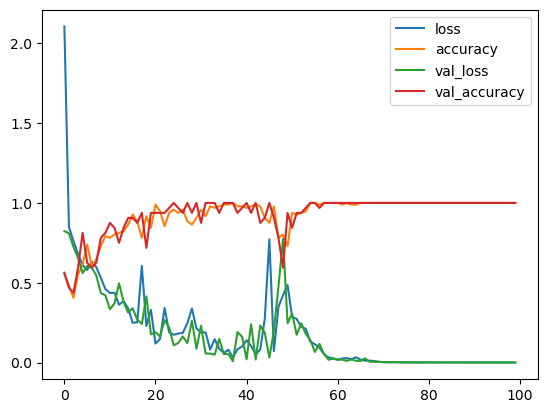

In [55]:
plt.figure(figsize = (8,5))
pd.DataFrame(history.history).plot()
plt.show()

### EVALUATING THE MODEL

In [56]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [57]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [58]:
for batch in test.as_numpy_iterator():
    x, y = batch
    y_pred = model.predict(x)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    acc.update_state(y, y_pred)

1/1 [==============================] - 0s 72ms/step


2023-08-08 10:58:16.056362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [59]:
print(f'Precision : {pre.result().numpy()}, Recall : {re.result().numpy()}, Accuracy : {acc.result().numpy()}')

Precision : 1.0, Recall : 1.0, Accuracy : 1.0


### TESTING THE MODEL

In [60]:
import cv2

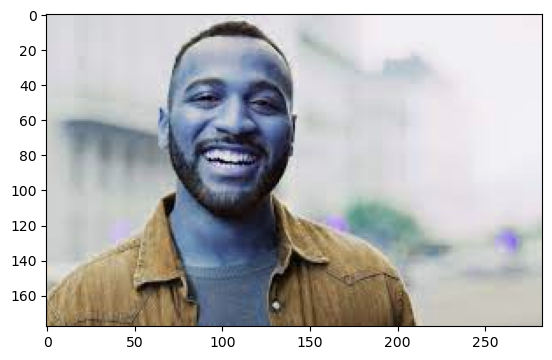

In [75]:
img = cv2.imread('Happy.jpeg')
plt.imshow(img)
plt.show()

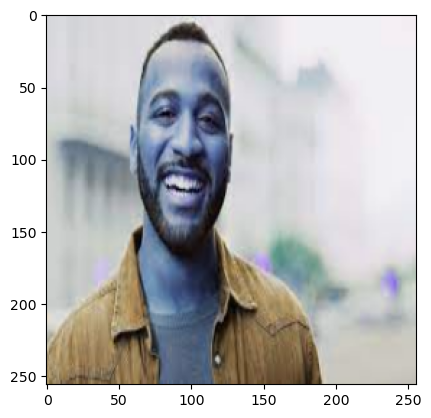

In [76]:
resized_img = tf.image.resize(img, (256,256))
plt.imshow(resized_img.numpy().astype(int))
plt.show()

In [77]:
yhat = model.predict(np.expand_dims(resized_img/255, 0))

1/1 [==============================] - 0s 12ms/step


In [78]:
yhat

array([[0.00051172]], dtype=float32)

In [79]:
if yhat >= 0.5:
    print("Cheer up bruda, why do you look sad?")
else:
    print("Yayy you look happy!")

Yayy you look happy!


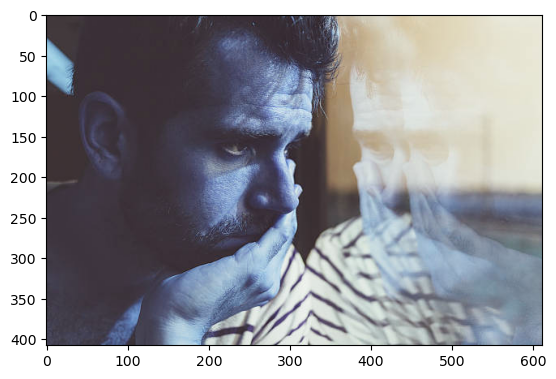

In [69]:
img = cv2.imread('sad.jpeg')
plt.imshow(img)
plt.show()

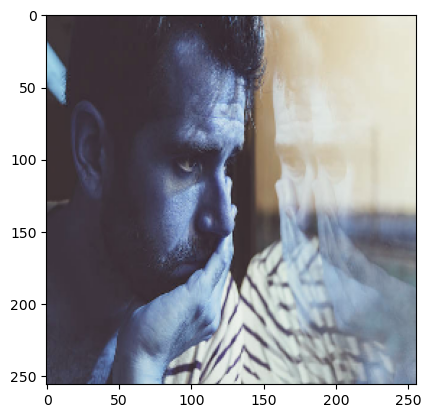

In [70]:
resized_img = tf.image.resize(img, (256,256))
plt.imshow(resized_img.numpy().astype(int))
plt.show()

In [71]:
yhat = model.predict(np.expand_dims(resized_img/255, 0))

1/1 [==============================] - 0s 10ms/step


In [72]:
yhat

array([[0.59848255]], dtype=float32)

In [74]:
if yhat >= 0.5:
    print("Cheer up bruda, why do you look sad?")
else:
    print("Yayy you look happy!")

Cheer up bruda, why do you look sad?


### SAVING THE MODEL

In [80]:
model.save(os.path.join('models', 'sentiment.h5'))

/Users/pranav/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
